In [1]:
# import necessary modules

import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import os
import sys
import glob
import pickle
import warnings
import tqdm
import pandas as pd
import librosa
import librosa.display as display
import biosppy
import scipy.signal as sig
from scipy.stats import zscore
from scipy.io import wavfile
from scipy.fft import fft,fftfreq
from scipy.fftpack import fft

warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib as mlp
mlp.rc("xtick",labelsize=10)
mlp.rc("ytick",labelsize=10)
mlp.rc("axes",labelsize=11)
plt.rcParams["figure.figsize"] = [11,5]
plt.rcParams["figure.dpi"] = 300

import tensorflow as tf
import sklearn
import tensorflow.keras as keras
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

CURR_DIR = os.getcwd()

In [2]:
MAIN_DIR = "."
if os.path.basename(os.getcwd())!="Silent-Interface-for-IOT-Devices":
    os.chdir("..")

DATA_DIR = os.path.join(MAIN_DIR,"new dataset")
FIG_DIR = os.path.join(MAIN_DIR,"figures")
PICKLE_DIR = os.path.join(MAIN_DIR,"pickles")
os.makedirs(FIG_DIR,exist_ok=True)
os.makedirs(PICKLE_DIR,exist_ok=True)

# hardware definitions
"""
https://docs.openbci.com/docs/02Cyton/CytonDataFormat#:~:text=By%20default%2C%20our%20Arduino%20sketch,of%200.02235%20microVolts%20per%20count
"""
SAMPLING_RATE = 250 #Hz
NUM_CHANNELS = 8 
ADC_RESOLUTION = 24 #bits
ADC_GAIN = 24.0
REF_VOLTAGE = 4.5 #Volts
SCALE_FACTOR = (REF_VOLTAGE/float((pow(2,23))-1)/ADC_GAIN)*1000000.0 #micro-volts

# dataset definitions
SPEAKER = ["RL","RN","SR","US"]
SESSION = ["session"+str(i) for i in range(1,9)]
MODE = ["mentally","mouthed"]
SENTENCES =["अबको समय सुनाउ","एउटा सङ्गित बजाउ","आजको मौसम बताउ","बत्तिको अवस्था बदल","पङ्खाको स्तिथी बदल"]
LABELS = np.array(SENTENCES)[[3, 2, 1, 4, 0, 3, 2, 1, 4, 0, 3, 2, 1, 4, 0]]
WORDS = ["समय","सङ्गित","मौसम","बत्ति","पङ्खा"]


## IMPORT DATASET

In [3]:
all_files = glob.glob(DATA_DIR+"/**/*.txt",recursive=True)
print("The files in the dataset: ",len(all_files))


The files in the dataset:  155


In [4]:
def parser(files,NORMALIZE=True,DEPLOY=False):
    
    """
    parser function to extract utterances from .txt file and store them in a dictionary
    """
    
    # PERCENTILES FOR LENGTH NORMALIZATION
    if(NORMALIZE==True):
        percentile_95 = 1602
        percentile_97 = 1614
        percentile_99 = 1648
        percentile_100 = 1875
    else:
        percentile_95 = percentile_97 = percentile_99 = percentile_100 = -1
        
    dataset = {"data":[], "speaker":[],"session":[],"labels":[]}
    
    def get_data(file):
        
        signal = read_data(file)
        
        if(DEPLOY==True):
            dataset["data"].extend(signal)
            return
        
        if(len(signal)!=15):
            return
        
        session = file.split("/")[-2]
        speaker = file.split("/")[-3]
        
        dataset["data"].extend(signal)
        dataset["speaker"].extend([speaker]*len(signal))
        dataset["session"].extend([session]*len(signal))
        dataset["labels"].extend(LABELS)
        
    
    def read_data(file):
        f = open(file, 'r')
        contents = map(lambda x : x.strip(), f.readlines())
        #the file starts with '%' and some instruction before data and removing these data 
        frames_original = list(filter(lambda x : x and x[0] != '%', contents))[1:]
        #the data row contains channels info digital trigger and accelerometer info separated by comma
        frames_original = list(map(lambda s : list(map( lambda ss: ss.strip(), s.split(','))), frames_original))
        # (8 channels) + digital triggers
        # the digital trigger is in a[16], used to indicate the utterance
        frames = list(map(lambda a: list(map(float, a[1:9])) + [float(a[16])] , frames_original))
        frames = np.array(frames)
        indices = []
        signal = []
        for index,f in enumerate(frames[:,-1]):
            if(bool(f) ^ bool(frames[(index+1) if ((index+1)<len(frames)) else index,-1]) ):
                indices.append(index)
                if len(indices)>1 and len(indices)%2==0:
                    frame_len = indices[len(indices)-1] - indices[len(indices)-2]
                    if(frame_len<percentile_99):
                        pad = int(np.ceil((percentile_99 - frame_len)/2))
                    else:
                        pad = 0
                    left_pad = indices[len(indices)-2] - pad
                    right_pad = indices[len(indices)-1] + pad
                    a_frame = (frames[left_pad:right_pad,:-1])[:percentile_99]
                    signal.append(a_frame)
    
        # convert to microVolts and return
        return np.array(signal)*SCALE_FACTOR
        
    for file,i in zip(files,tqdm.tqdm(range(1,len(files)+1),desc="PARSING DATA")):
        get_data(file)
    
    return dataset

In [26]:

if "data_dict.pickle" in os.listdir(PICKLE_DIR):
    print("Fetching raw data from pickle file ...")
    all_data = pickle.load(open(os.path.join(PICKLE_DIR,"data_dict.pickle"),"rb"))
    print("Done!")
else:
    all_data = parser(all_files,NORMALIZE=False)
    pickle.dump(all_data,open(os.path.join(PICKLE_DIR,"data_dict.pickle"),"wb"))



PARSING DATA:  99%|█████████▉| 154/155 [01:35<00:00,  1.62it/s]


In [6]:
print(type(all_data))
print(all_data.keys())
DATA_LENGTH = len(all_data["labels"])
print([len(x[-1]) for x in all_data.items()])

<class 'dict'>
dict_keys(['data', 'speaker', 'session', 'labels'])
[2175, 2175, 2175, 2175]


## DATA AUGMENTATION

### NOISE ADDITION

In [7]:
# def add_noise(data,FACTOR=0.9):
#     noise = np.random.randn(len(data))
# #     return FACTOR * noise
#     new_data = data + FACTOR * noise
#     return new_data.astype(type(data[0]))

### TIME SHIFTING

In [8]:
def time_shift(data,SHIFT_LEN=100,SHIFT_DIR ="RIGHT",index=0):
    if SHIFT_DIR != "RIGHT":
        SHIFT_LEN = - SHIFT_LEN
        index = -1
    shifted_data = np.roll(data,SHIFT_LEN)
    if SHIFT_LEN>0:
        shifted_data[:SHIFT_LEN] = data[index]
    else:
        shifted_data[SHIFT_LEN:] = data[index]
    return shifted_data

In [9]:
for i in range(DATA_LENGTH):
    aug_data = []
    for j in range(8):
        temp_data1 = time_shift(all_data["data"][i][:,j],SHIFT_DIR="LEFT")
        aug_data.append(temp_data1)
        
    all_data["data"].extend([(np.array(aug_data)).T])
    all_data["labels"].extend([all_data["labels"][i]])
    all_data["speaker"].extend([all_data["speaker"][i]])
    all_data["session"].extend([all_data["session"][i]])

In [10]:
for i in range(DATA_LENGTH):
    aug_data = []
    for j in range(8):
        temp_data2 = time_shift(all_data["data"][i][:,j],SHIFT_DIR="RIGHT")
        aug_data.append(temp_data2)
        
    all_data["data"].extend([(np.array(aug_data)).T])
    all_data["labels"].extend([all_data["labels"][i]])
    all_data["speaker"].extend([all_data["speaker"][i]])
    all_data["session"].extend([all_data["session"][i]])

In [11]:
print([len(x[-1]) for x in all_data.items()])

[6525, 6525, 6525, 6525]


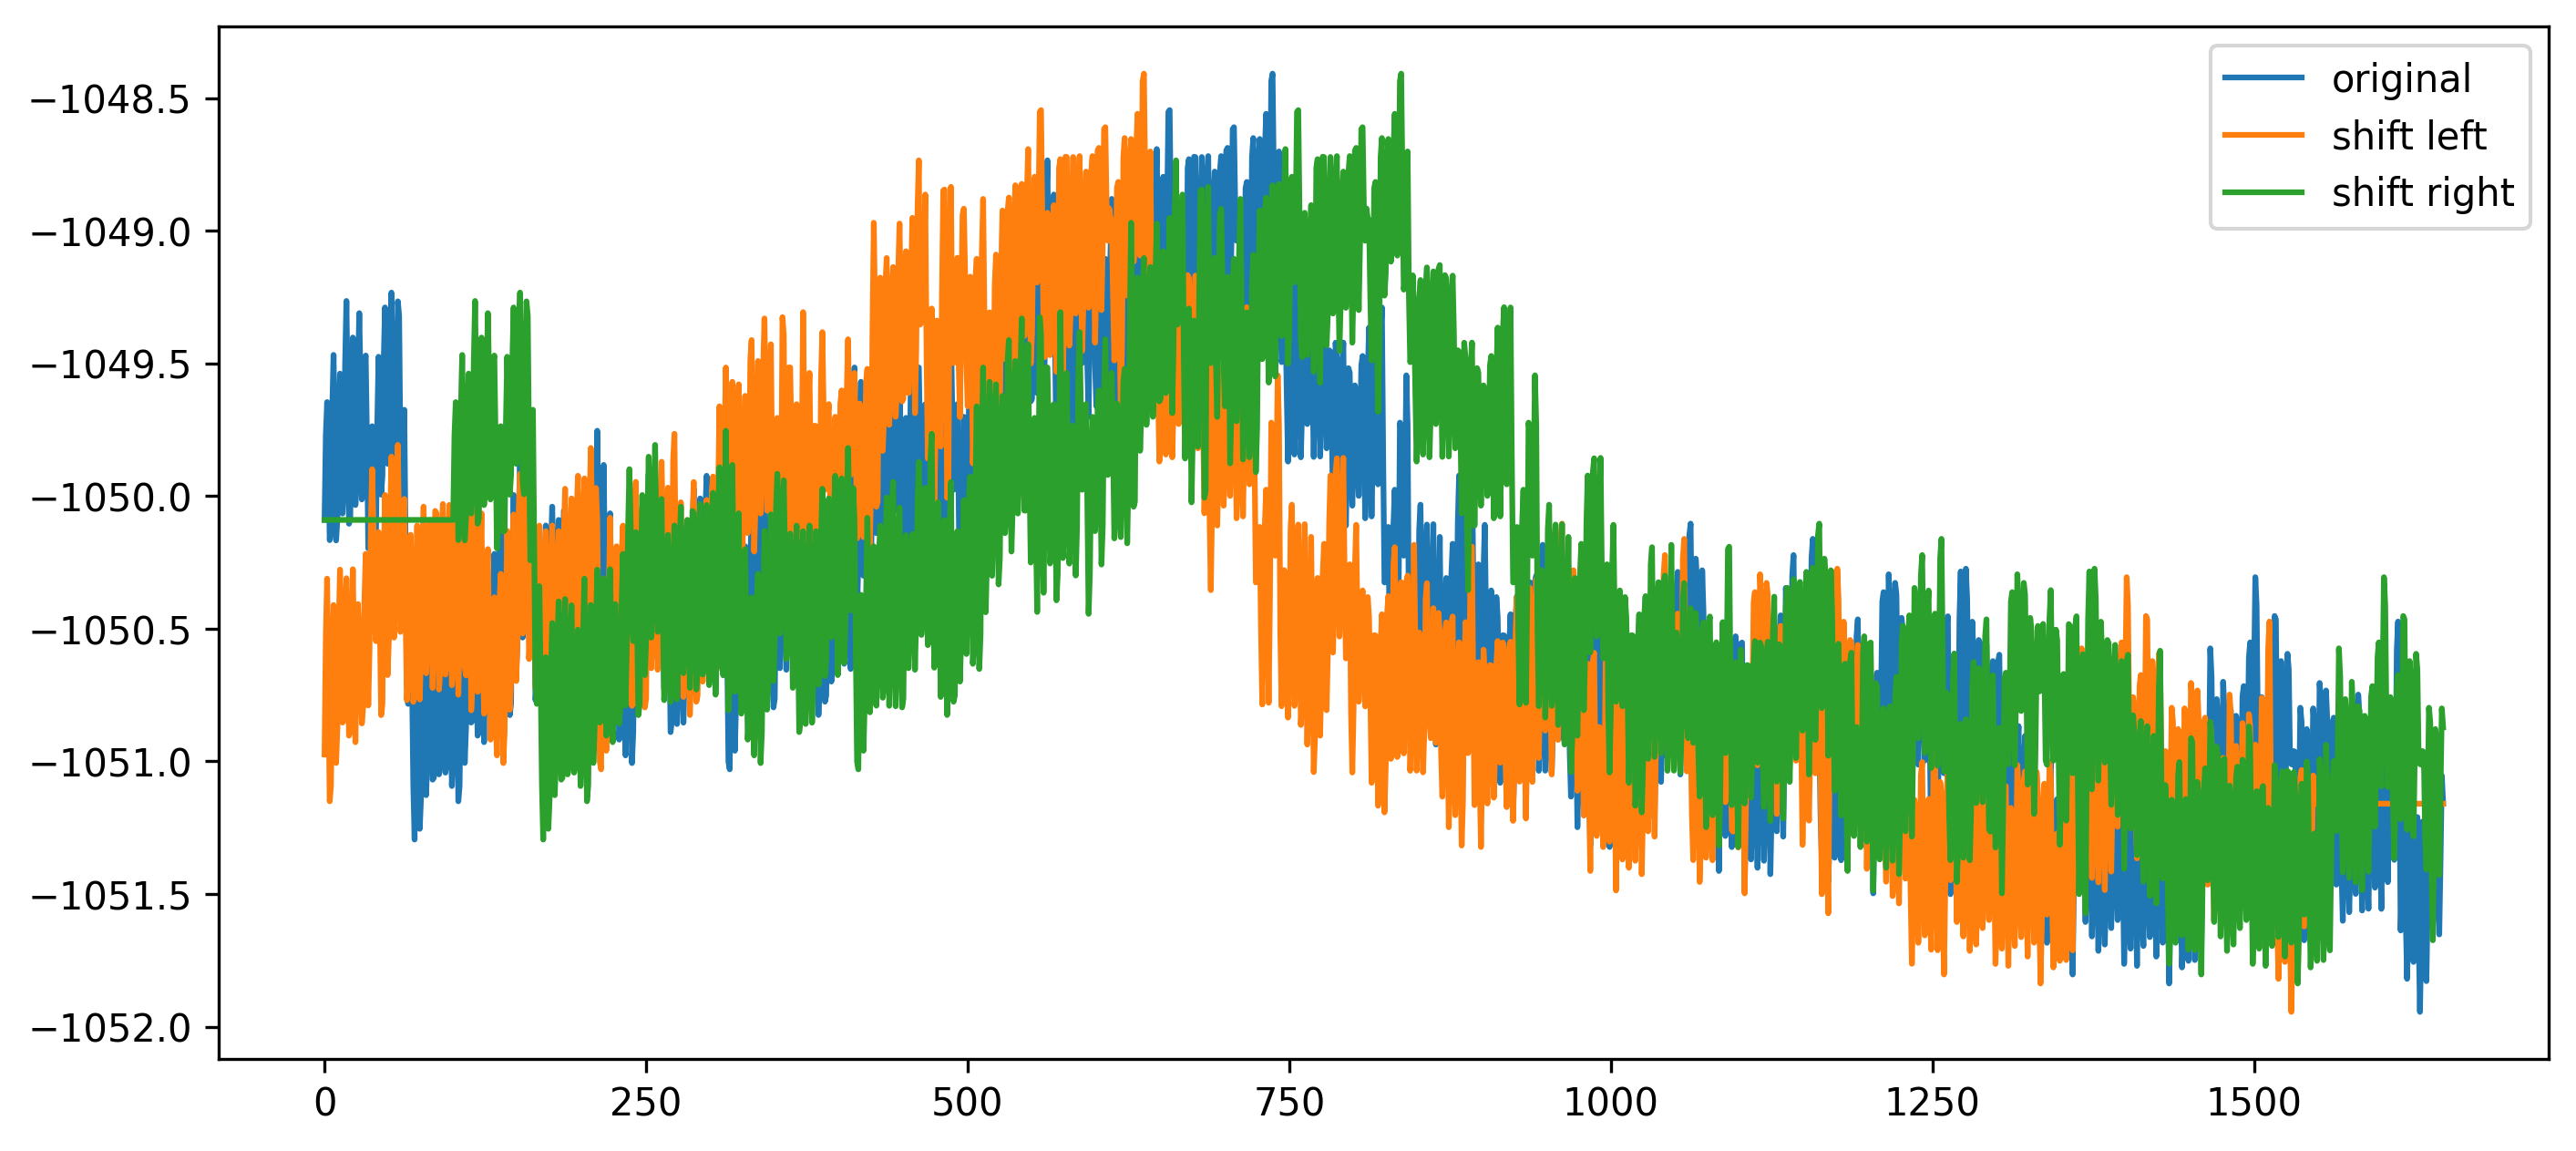

In [12]:
plt.plot(all_data["data"][0][:,0])
plt.plot(all_data["data"][2175][:,0])
plt.plot(all_data["data"][4350][:,0])
plt.legend(["original","shift left","shift right"])
plt.show()

## PROCESS SIGNAL

In [13]:
def signal_pipeline(data,RICKER=False):

    """
    CORRECT DC DRIFT --> CORRECT DC BIAS --> SMOOTHING SIGNAL --> NORMALIZE DATA --> FILTER DATA 	
    """
    filter_data = []

    def digital_filter(data,HPF=0.5,LPF=10,H_ORDER=4,L_ORDER=4,SR=250):
        """
        HPF --> NOTCH --> LPF --> RICKER CONVOLUTION
        """

        # highpass filter
        f_signal = biosppy.signals.tools.filter_signal(data,ftype="butter",band="highpass",order=H_ORDER,sampling_rate=SR,frequency=HPF)
        # notch filter
        b,a = sig.iirnotch(50,30,SR)
        f_signal = sig.lfilter(b,a,f_signal[0])

        # lowpass filter
        f_signal = biosppy.signals.tools.filter_signal(f_signal,ftype="butter",band="lowpass",order=L_ORDER,sampling_rate=SR,frequency=LPF)

        if(RICKER==True):
            # RICKER CONVOLUTION TO REMOVE HEARTBEAT ARTIFACTS
            ricker_width = 35 * SR // 250
            ricker_sigma = 4.0 * SR / 250
            ricker = sig.ricker(ricker_width,ricker_sigma)
            # normalize ricker
            ricker = np.array(ricker, np.float32) / np.sum(np.abs(ricker))
            convolution = sig.convolve(f_signal[0],ricker,mode="same")
            return (f_signal[0]-2*convolution)

        return f_signal[0]

    def process_signal(data):
        f_data = []
        for i in range(8):
            # correction of DC drift
            c_data = data[:,i]- data[0,i]

            # correct DC bias
            c_data = c_data - np.mean(c_data)

            # normalize and filter data
            c_data = digital_filter(c_data)
            f_data.append(c_data)

        return np.array(f_data).T

    for d,i in zip(data,tqdm.tqdm(range(1,len(data)+1),desc="PROCESSING DATA: ")):
        temp_data = process_signal(d)
        filter_data.extend([temp_data])

    return filter_data


In [27]:
if "data_dict_filtered.pickle" in os.listdir(PICKLE_DIR):
    print("Fetching filtered data from pickle file ...")
    all_data_filtered = pickle.load(open(os.path.join(PICKLE_DIR,"data_dict_filtered.pickle"),"rb"))
    print("Done!")
else:
    all_data_filtered = all_data.copy()
    all_data_filtered["data"] = signal_pipeline(all_data["data"])
    pickle.dump(all_data_filtered,open(os.path.join(PICKLE_DIR,"data_dict_filtered.pickle"),"wb"))


PROCESSING DATA: 100%|█████████▉| 2174/2175 [00:28<00:00, 76.58it/s]


In [28]:
print(type(all_data_filtered))
print(all_data_filtered.keys())
print([len(x[-1]) for x in all_data_filtered.items()])

<class 'dict'>
dict_keys(['data', 'speaker', 'session', 'labels'])
[2175, 2175, 2175, 2175]


In [29]:
print(np.array(all_data_filtered["data"]).shape)

(2175,)


In [31]:
# plt.plot(all_data_filtered["data"][0][:,0])
# plt.plot(all_data_filtered["data"][2175][:,0])
# plt.plot(all_data_filtered["data"][4350][:,0])
# plt.legend(["original","shift left","shift right"])
# plt.show()

## ANALYSE DATA

In [32]:
df_raw = pd.DataFrame(all_data)
df = pd.DataFrame(all_data_filtered)

In [33]:
df_raw.head()

,data,speaker,session,labels
0,"[[-1049.8434508964065, 399.25921403819643, -13...",US,session7,बत्तिको अवस्था बदल
1,"[[-1050.689237414135, 398.88399285930313, -143...",US,session7,आजको मौसम बताउ
2,"[[-1052.669636897476, 396.92306384085884, -146...",US,session7,एउटा सङ्गित बजाउ
3,"[[-1054.2258771051768, 395.2119330290029, -147...",US,session7,पङ्खाको स्तिथी बदल
4,"[[-1055.2971019204977, 394.6189133089231, -143...",US,session7,अबको समय सुनाउ


In [34]:
df.head()

,data,speaker,session,labels
0,"[[-0.3244954805823927, -0.2587778311916298, -0...",US,session7,बत्तिको अवस्था बदल
1,"[[-0.004593459567215607, -0.01627544470757908,...",US,session7,आजको मौसम बताउ
2,"[[0.02774417735436103, 0.06303822272886009, 0....",US,session7,एउटा सङ्गित बजाउ
3,"[[0.08088927191601883, 0.08411127868340676, 0....",US,session7,पङ्खाको स्तिथी बदल
4,"[[-0.08817097956829474, -0.17510332206643656, ...",US,session7,अबको समय सुनाउ


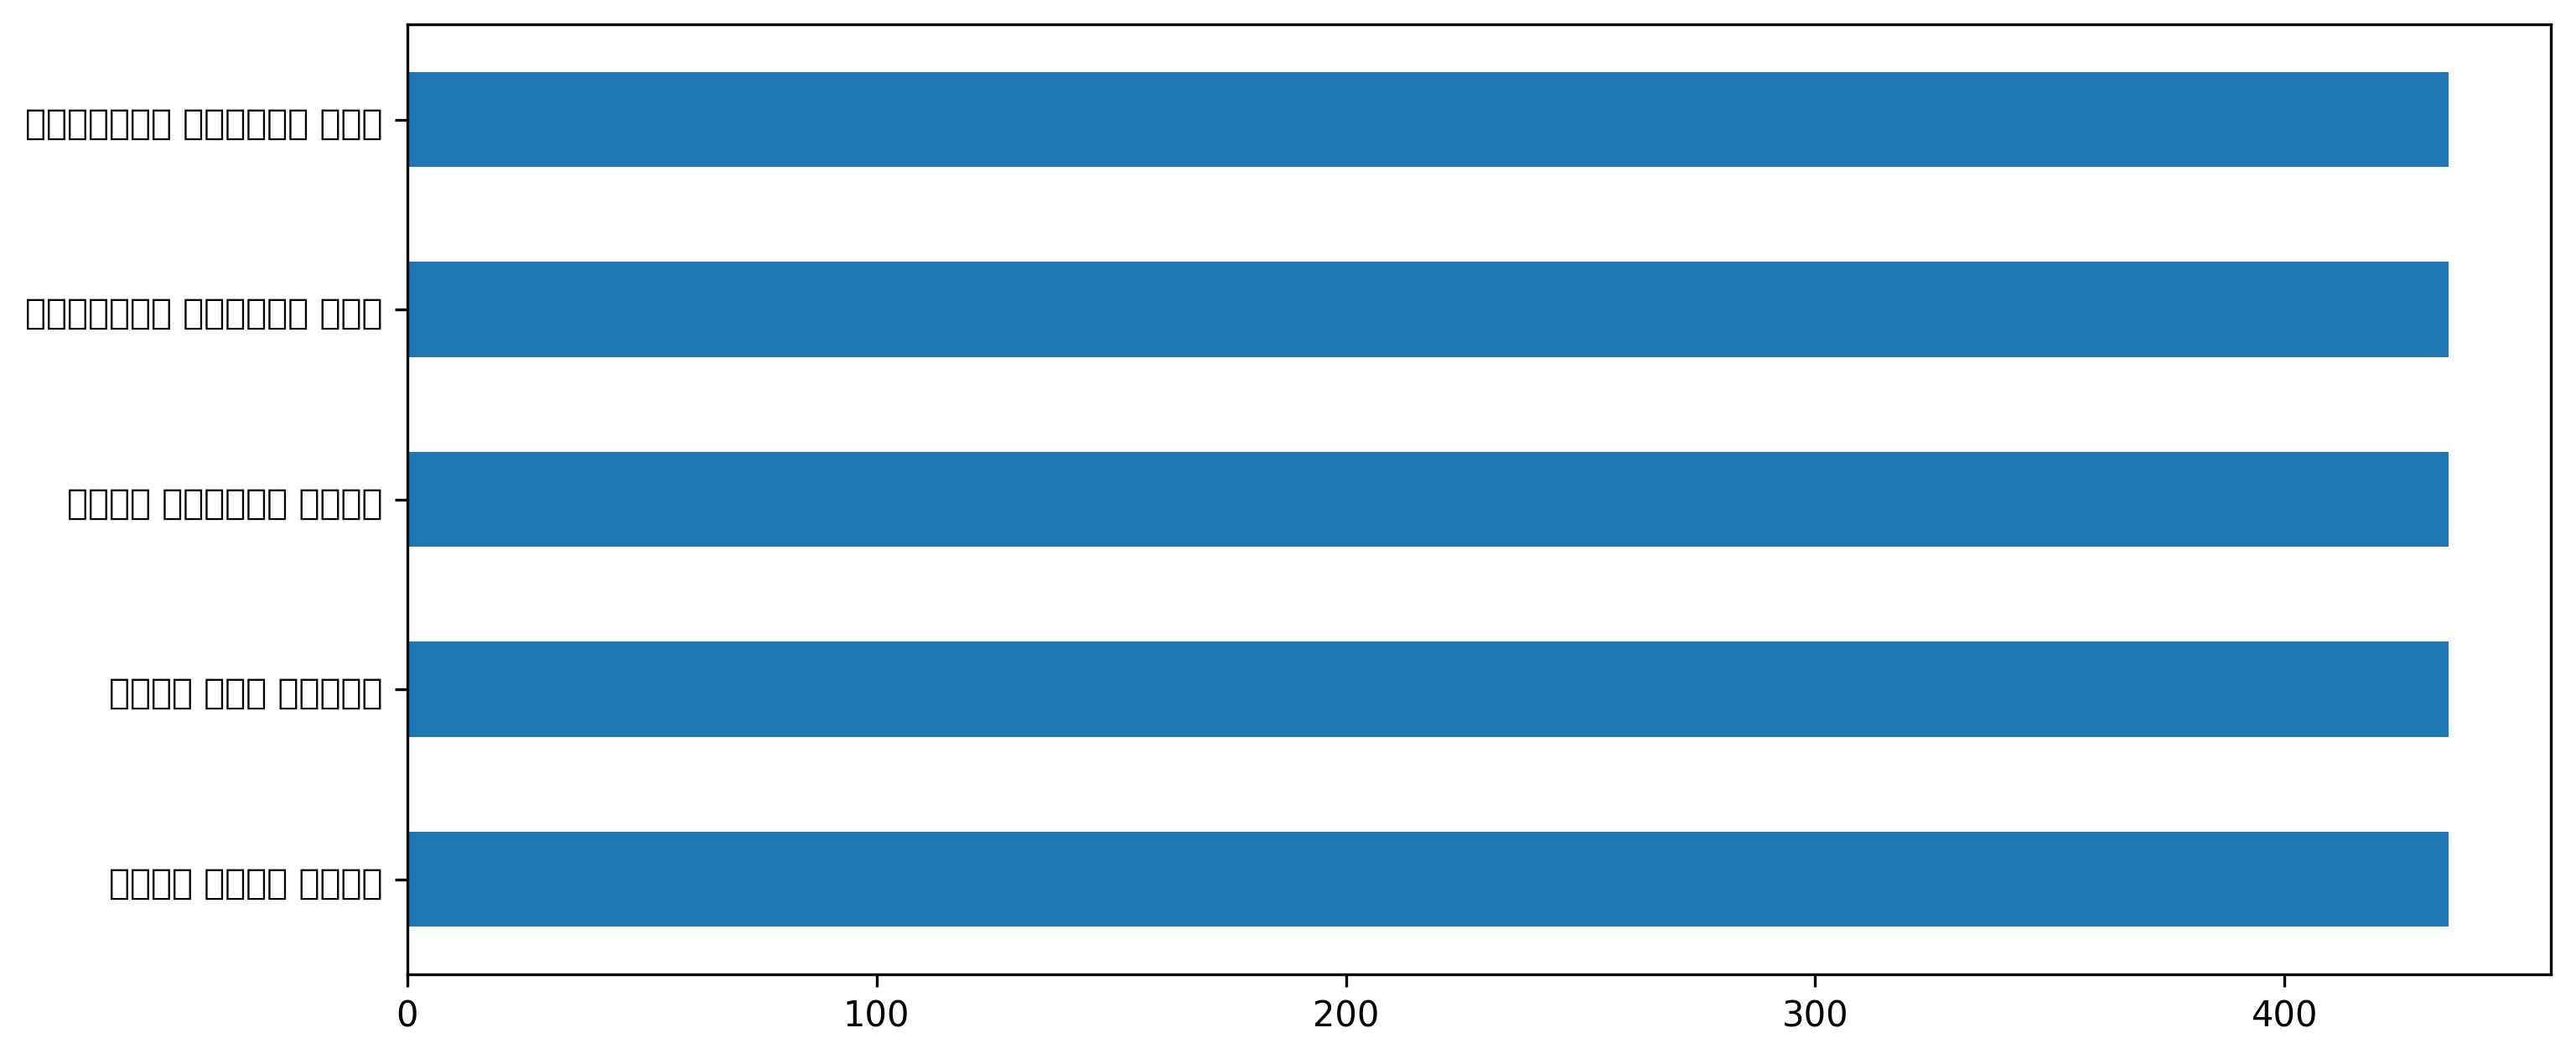

In [35]:
# df["speaker"].value_counts().plot.barh()
df["labels"].value_counts().plot.barh()
plt.show()

In [36]:
data_length = [x.shape[0]/SAMPLING_RATE for x in df_raw["data"]]

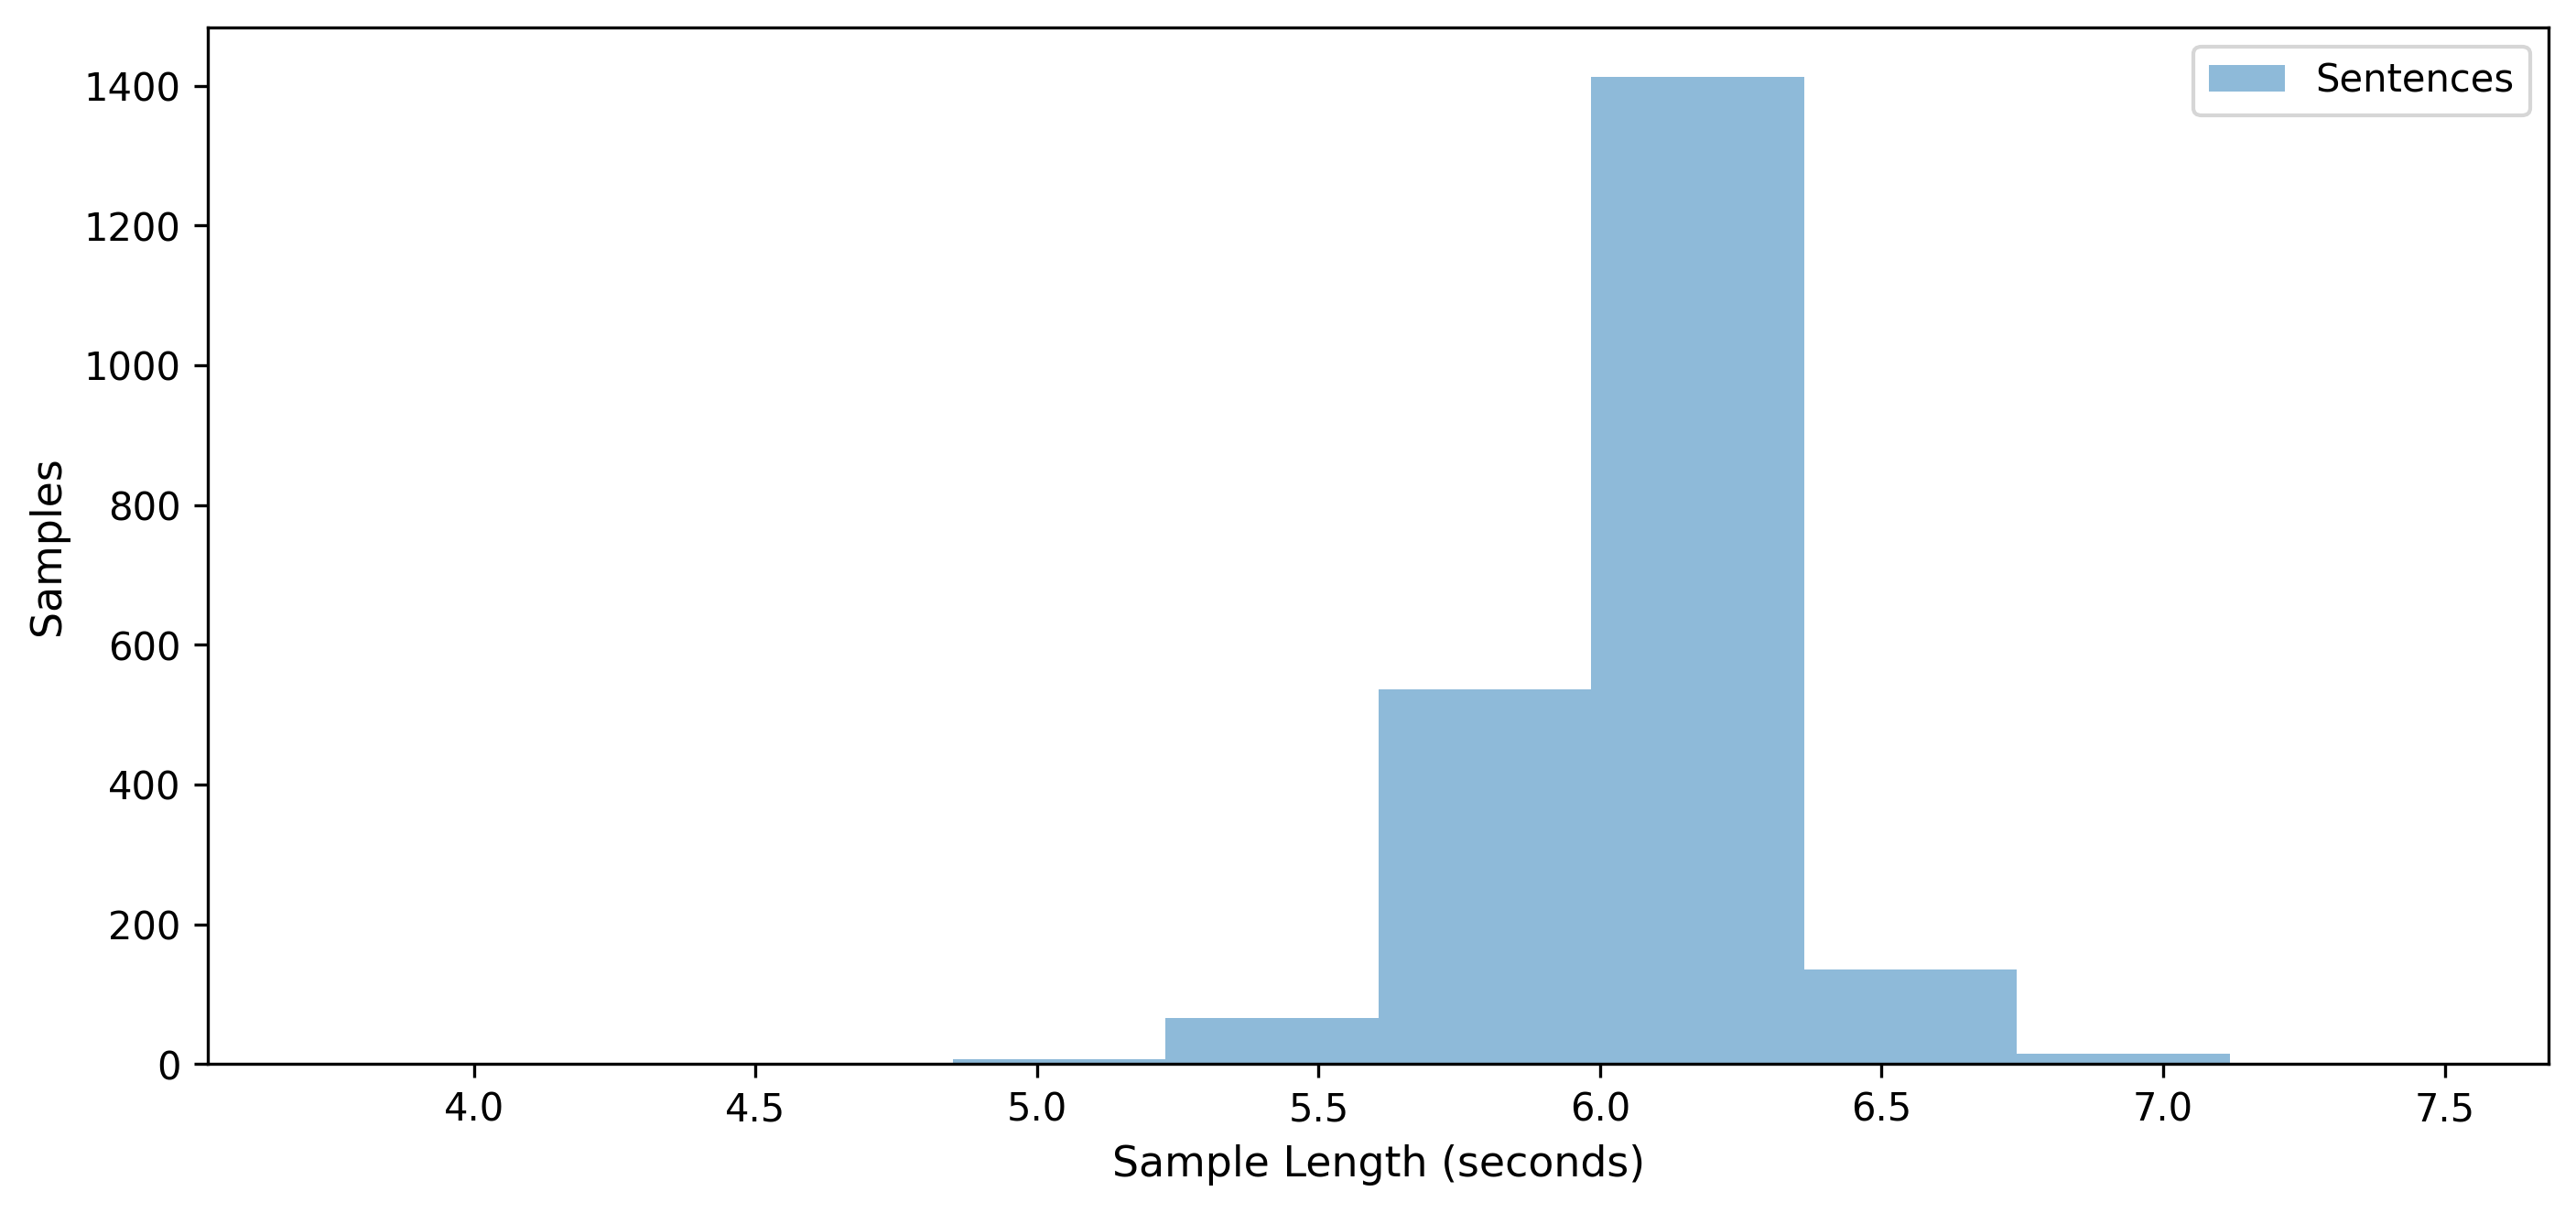

In [37]:
plt.hist(data_length,alpha=0.5)
plt.xlabel("Sample Length (seconds)")
plt.ylabel("Samples")
plt.legend(["Sentences"])
# save_fig("length distribution")
plt.show()

In [38]:
print("Max length of sentence utterances in seconds: %.2fs" % np.max(data_length))
print("Min length of sentence utterances in seconds: %.2fs" % np.min(data_length))
print("Avg length of sentence utterances in seconds: %.2fs" % np.mean(data_length))

Max length of sentence utterances in seconds: 7.50s
Min length of sentence utterances in seconds: 3.72s
Avg length of sentence utterances in seconds: 6.08s


In [39]:
all_sent_RL = df.query('speaker=="RL"')
all_sent_US = df.query('speaker=="US"')
all_sent_length_RL = [x.shape[0]/SAMPLING_RATE for x in all_sent_RL["data"]]
all_sent_length_US = [x.shape[0]/SAMPLING_RATE for x in all_sent_US["data"]]

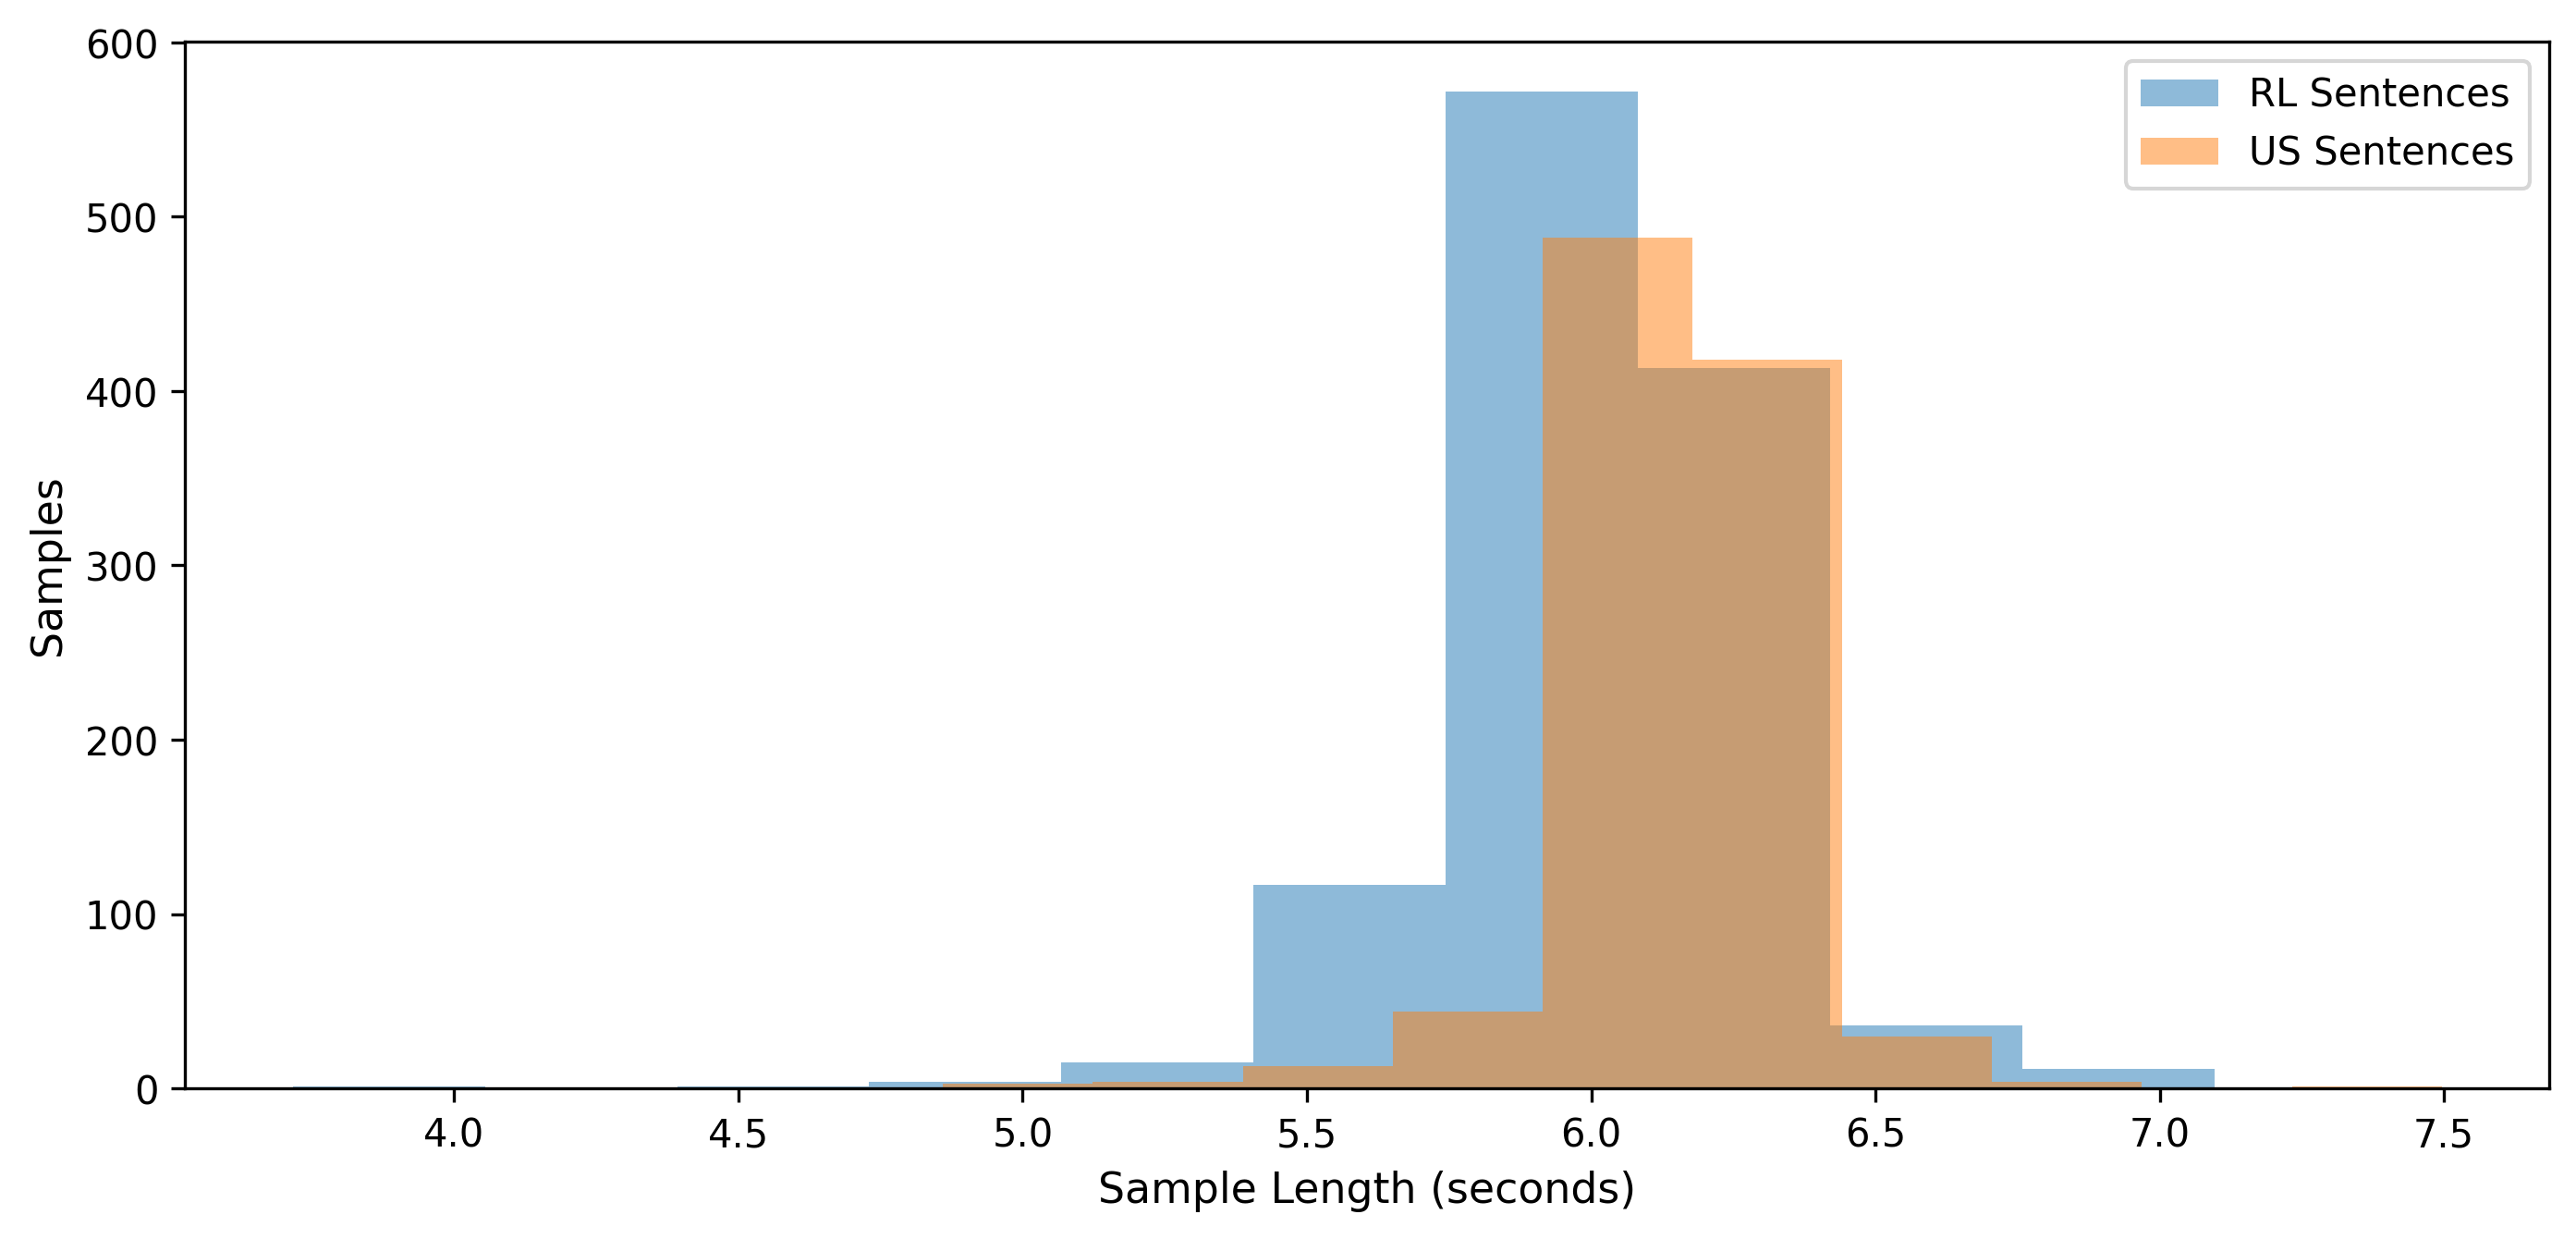

In [40]:
plt.hist(all_sent_length_RL,alpha=0.5)
plt.hist(all_sent_length_US,alpha=0.5)
plt.xlabel("Sample Length (seconds)")
plt.ylabel("Samples")
# save_fig("length distribution")
plt.legend(["RL Sentences","US Sentences"])
plt.show()

In [51]:
for i in [3,10,95,97,99,100]:
    print("%d percentile of data length: "% i,int(np.percentile(data_length,i)*250))
# take data from 1395 to 1663

3 percentile of data length:  1395
10 percentile of data length:  1447
95 percentile of data length:  1601
97 percentile of data length:  1616
99 percentile of data length:  1663
100 percentile of data length:  1874


## VISUALIZE DATA

In [56]:
def get_sample(index, speaker, label = "आजको मौसम बताउ"):
    return df.query('speaker=="'+speaker+'" and labels=="'+ label+'"')["data"].iloc[index]

In [52]:
def FFT(data1, data2, MODE):
    plt.suptitle(MODE)
    plt.subplot(211).set_title("RL")
    N = len(data1)
    for i in range(NUM_CHANNELS):
        y = fft(zscore(data1[:,i]))
        x = fftfreq(N,1/SAMPLING_RATE)
        plt.plot(abs(x),abs(y),alpha=0.6)

    plt.ylabel("Amplitude (uV)")

    plt.subplot(212).set_title("US")
    N = len(data2)
    for i in range(NUM_CHANNELS):
        y = fft(zscore(data2[:,i]))
        x = fftfreq(N,1/SAMPLING_RATE)
        plt.plot(abs(x),abs(y),alpha=0.6)

    plt.ylabel("Amplitude (uV)")
    plt.title("US")
    plt.show()

In [53]:
def power_spec(data1,data2,MODE):
    plt.suptitle(MODE)
    plt.subplot(211).set_title("RL")
    for i in range(NUM_CHANNELS):
        power = biosppy.signals.tools.power_spectrum(data1[:,i],sampling_rate=SAMPLING_RATE)
        plt.plot(power[0],power[1],alpha=0.6)
    plt.ylabel("Power")

    plt.subplot(212).set_title("US")
    for i in range(NUM_CHANNELS):
        power = biosppy.signals.tools.power_spectrum(data2[:,i],sampling_rate=SAMPLING_RATE)
        plt.plot(power[0],power[1],alpha=0.6)
    plt.ylabel("Power")
    plt.title("US")
    plt.show()

In [78]:
# def STFT(data1,data2,MODE,channel=4):
#     plt.suptitle(MODE)
#     plt.subplot(121).set_title("RL")
#     f, t, Zxx = sig.stft(data1[:,channel], fs=SAMPLING_RATE, nperseg=10)
#     plt.pcolormesh(t, f, Zxx, shading='gouraud',cmap="magma")
# #     nperseg change garera herne
#     plt.ylabel('Frequency [Hz]')
#     plt.xlabel('Time [sec]')
#     plt.ylim([0,20])
# #     plt.colorbar(format='%+2.0f dB')
    
#     plt.subplot(122).set_title("US")
#     f, t, Zxx = sig.stft(data2[:,channel], fs=SAMPLING_RATE, nperseg=10)
#     plt.pcolormesh(t, f, Zxx, shading='gouraud',cmap="magma")
# #     plt.colorbar()
# #     plt.ylabel('Frequency [Hz]')
#     plt.xlabel('Time [sec]')
#     plt.ylim([0,20])
# #     plt.colorbar(format='%+2.0f dB')
#     plt.show()

In [75]:
def SPECTOGRAM(data1,data2,MODE,channel=4):
    plt.suptitle(MODE)
    plt.subplot(121).set_title("RL")
    M = 50
    win = sig.windows.hamming(M)
    f, t, Sxx = sig.spectrogram(data1[:,channel], fs=SAMPLING_RATE, window = win, nperseg=M)
#     print(Sxx)
    plt.pcolormesh(t, f, Sxx, shading='gouraud',cmap="magma")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim([0,20])
#     plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(122).set_title("US")
    win = sig.windows.hanning(M)    
    f, t, Sxx = sig.spectrogram(data2[:,channel], fs=SAMPLING_RATE, window = win, nperseg=M)
    plt.pcolormesh(t, f, Sxx, shading='gouraud',cmap="magma")
#     plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim([0,20])
#     plt.colorbar(format='%+2.0f dB')
    plt.show()

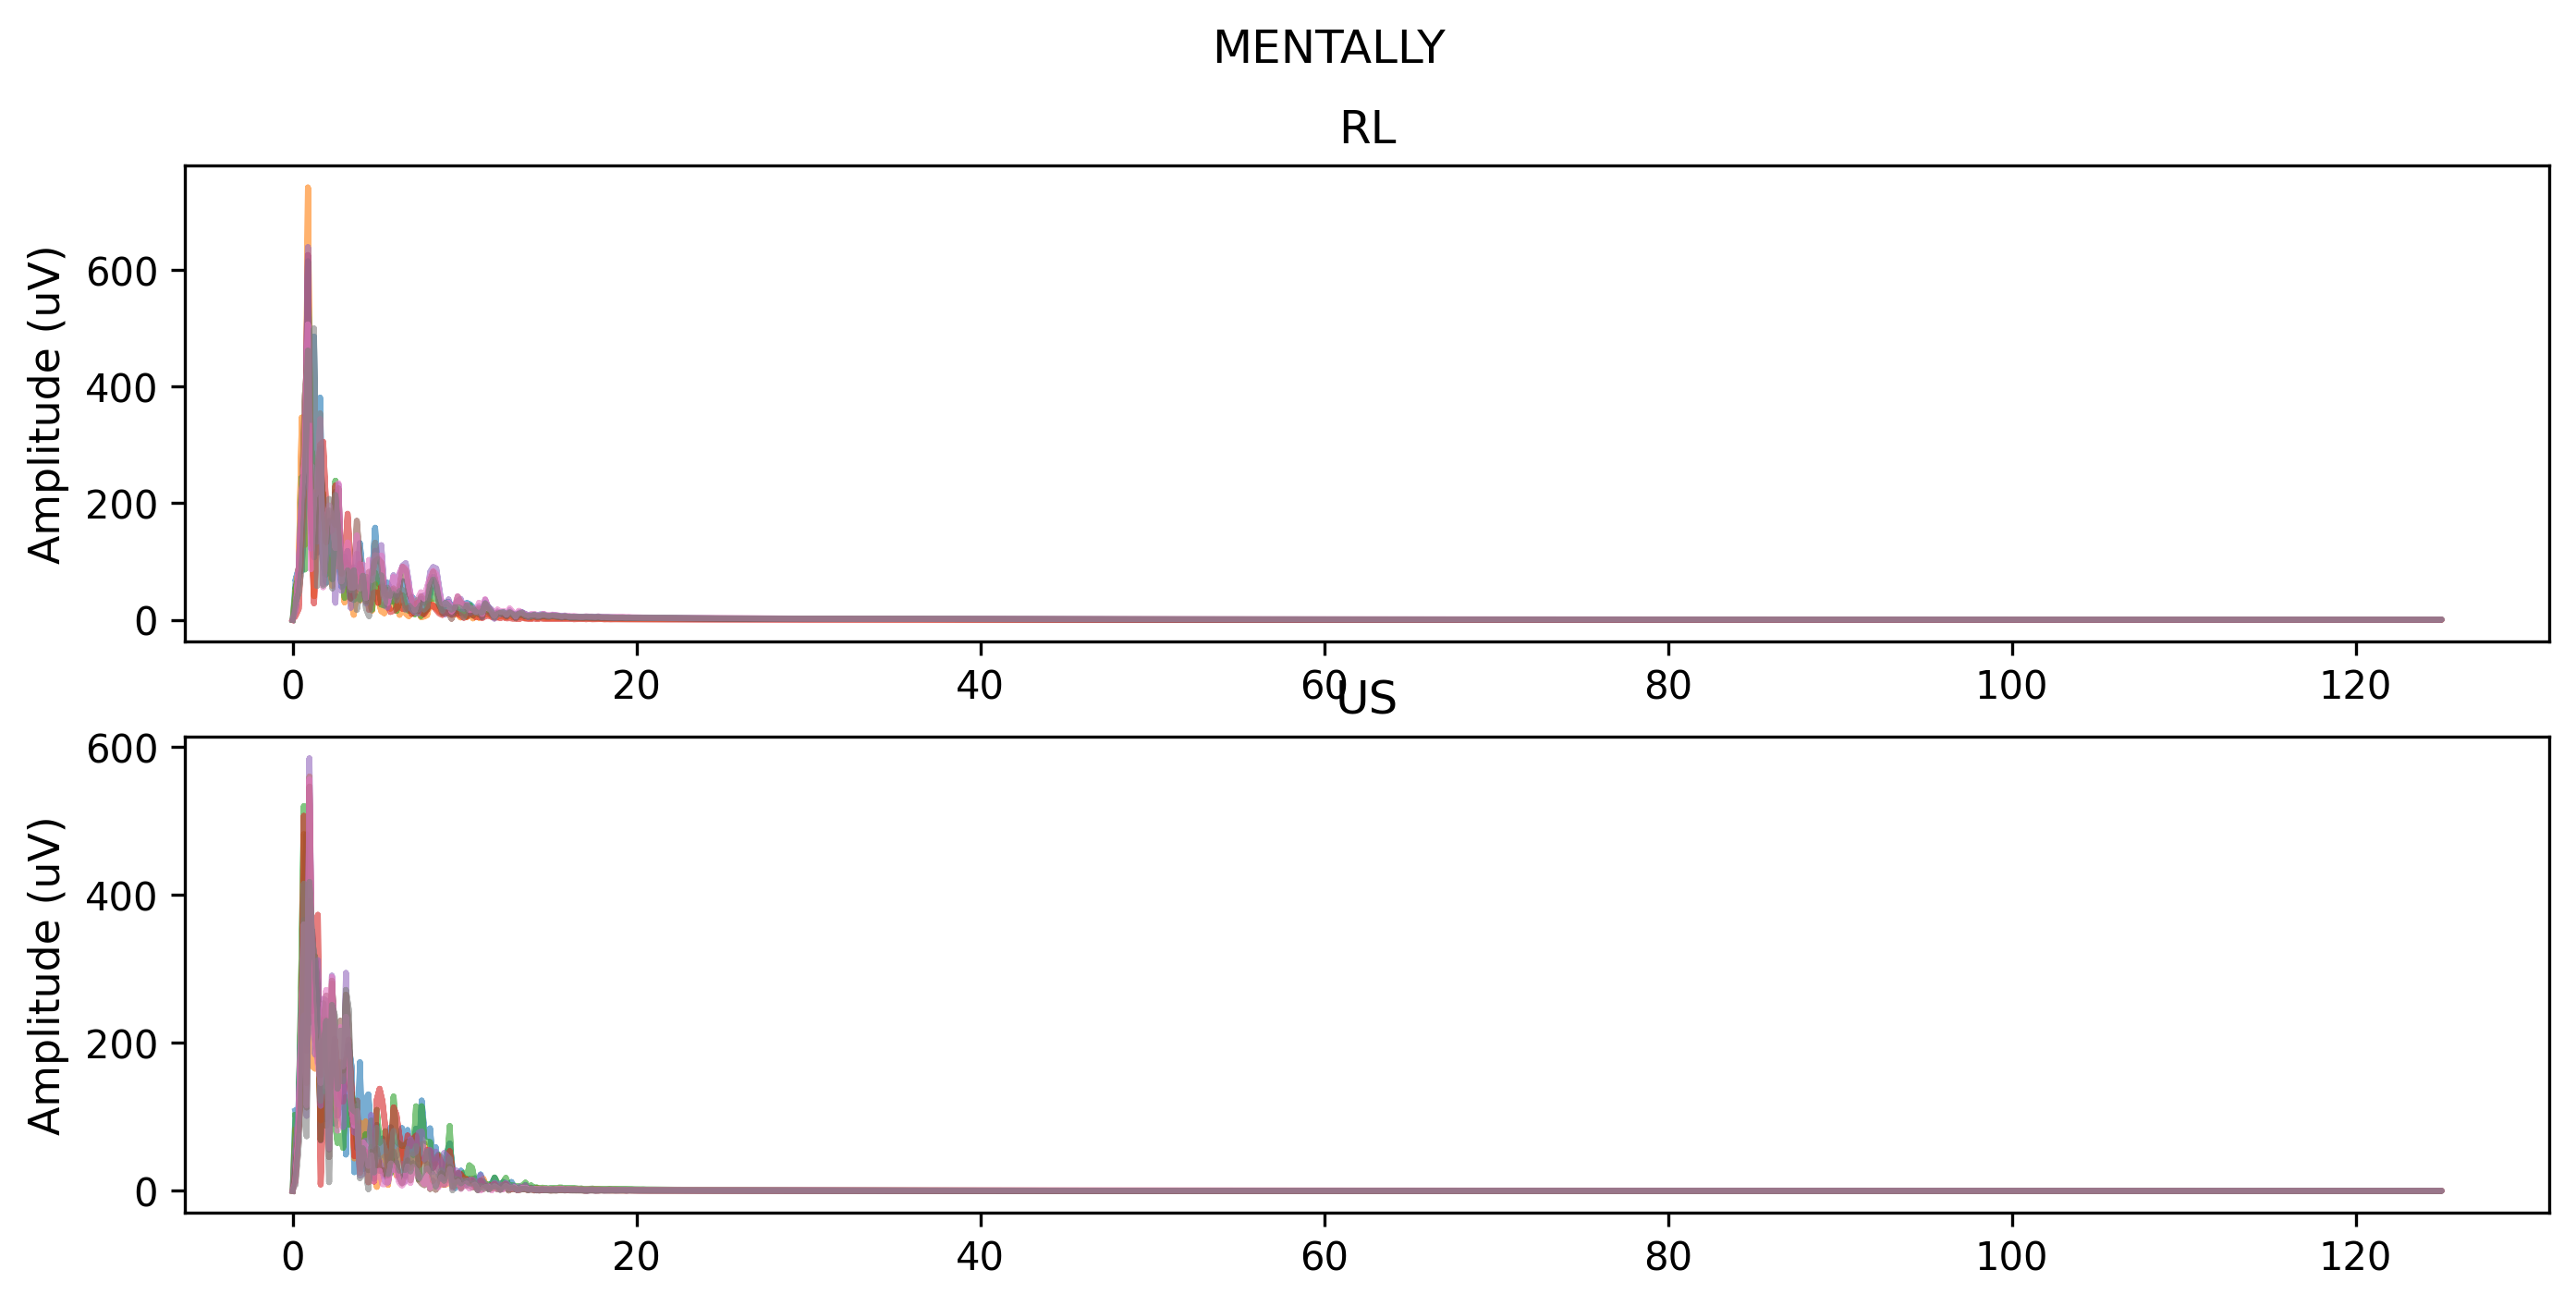

In [67]:
FFT(data1=get_sample(1, 'RL', SENTENCES[0]),data2=get_sample(1, 'US', SENTENCES[0]),MODE="MENTALLY")

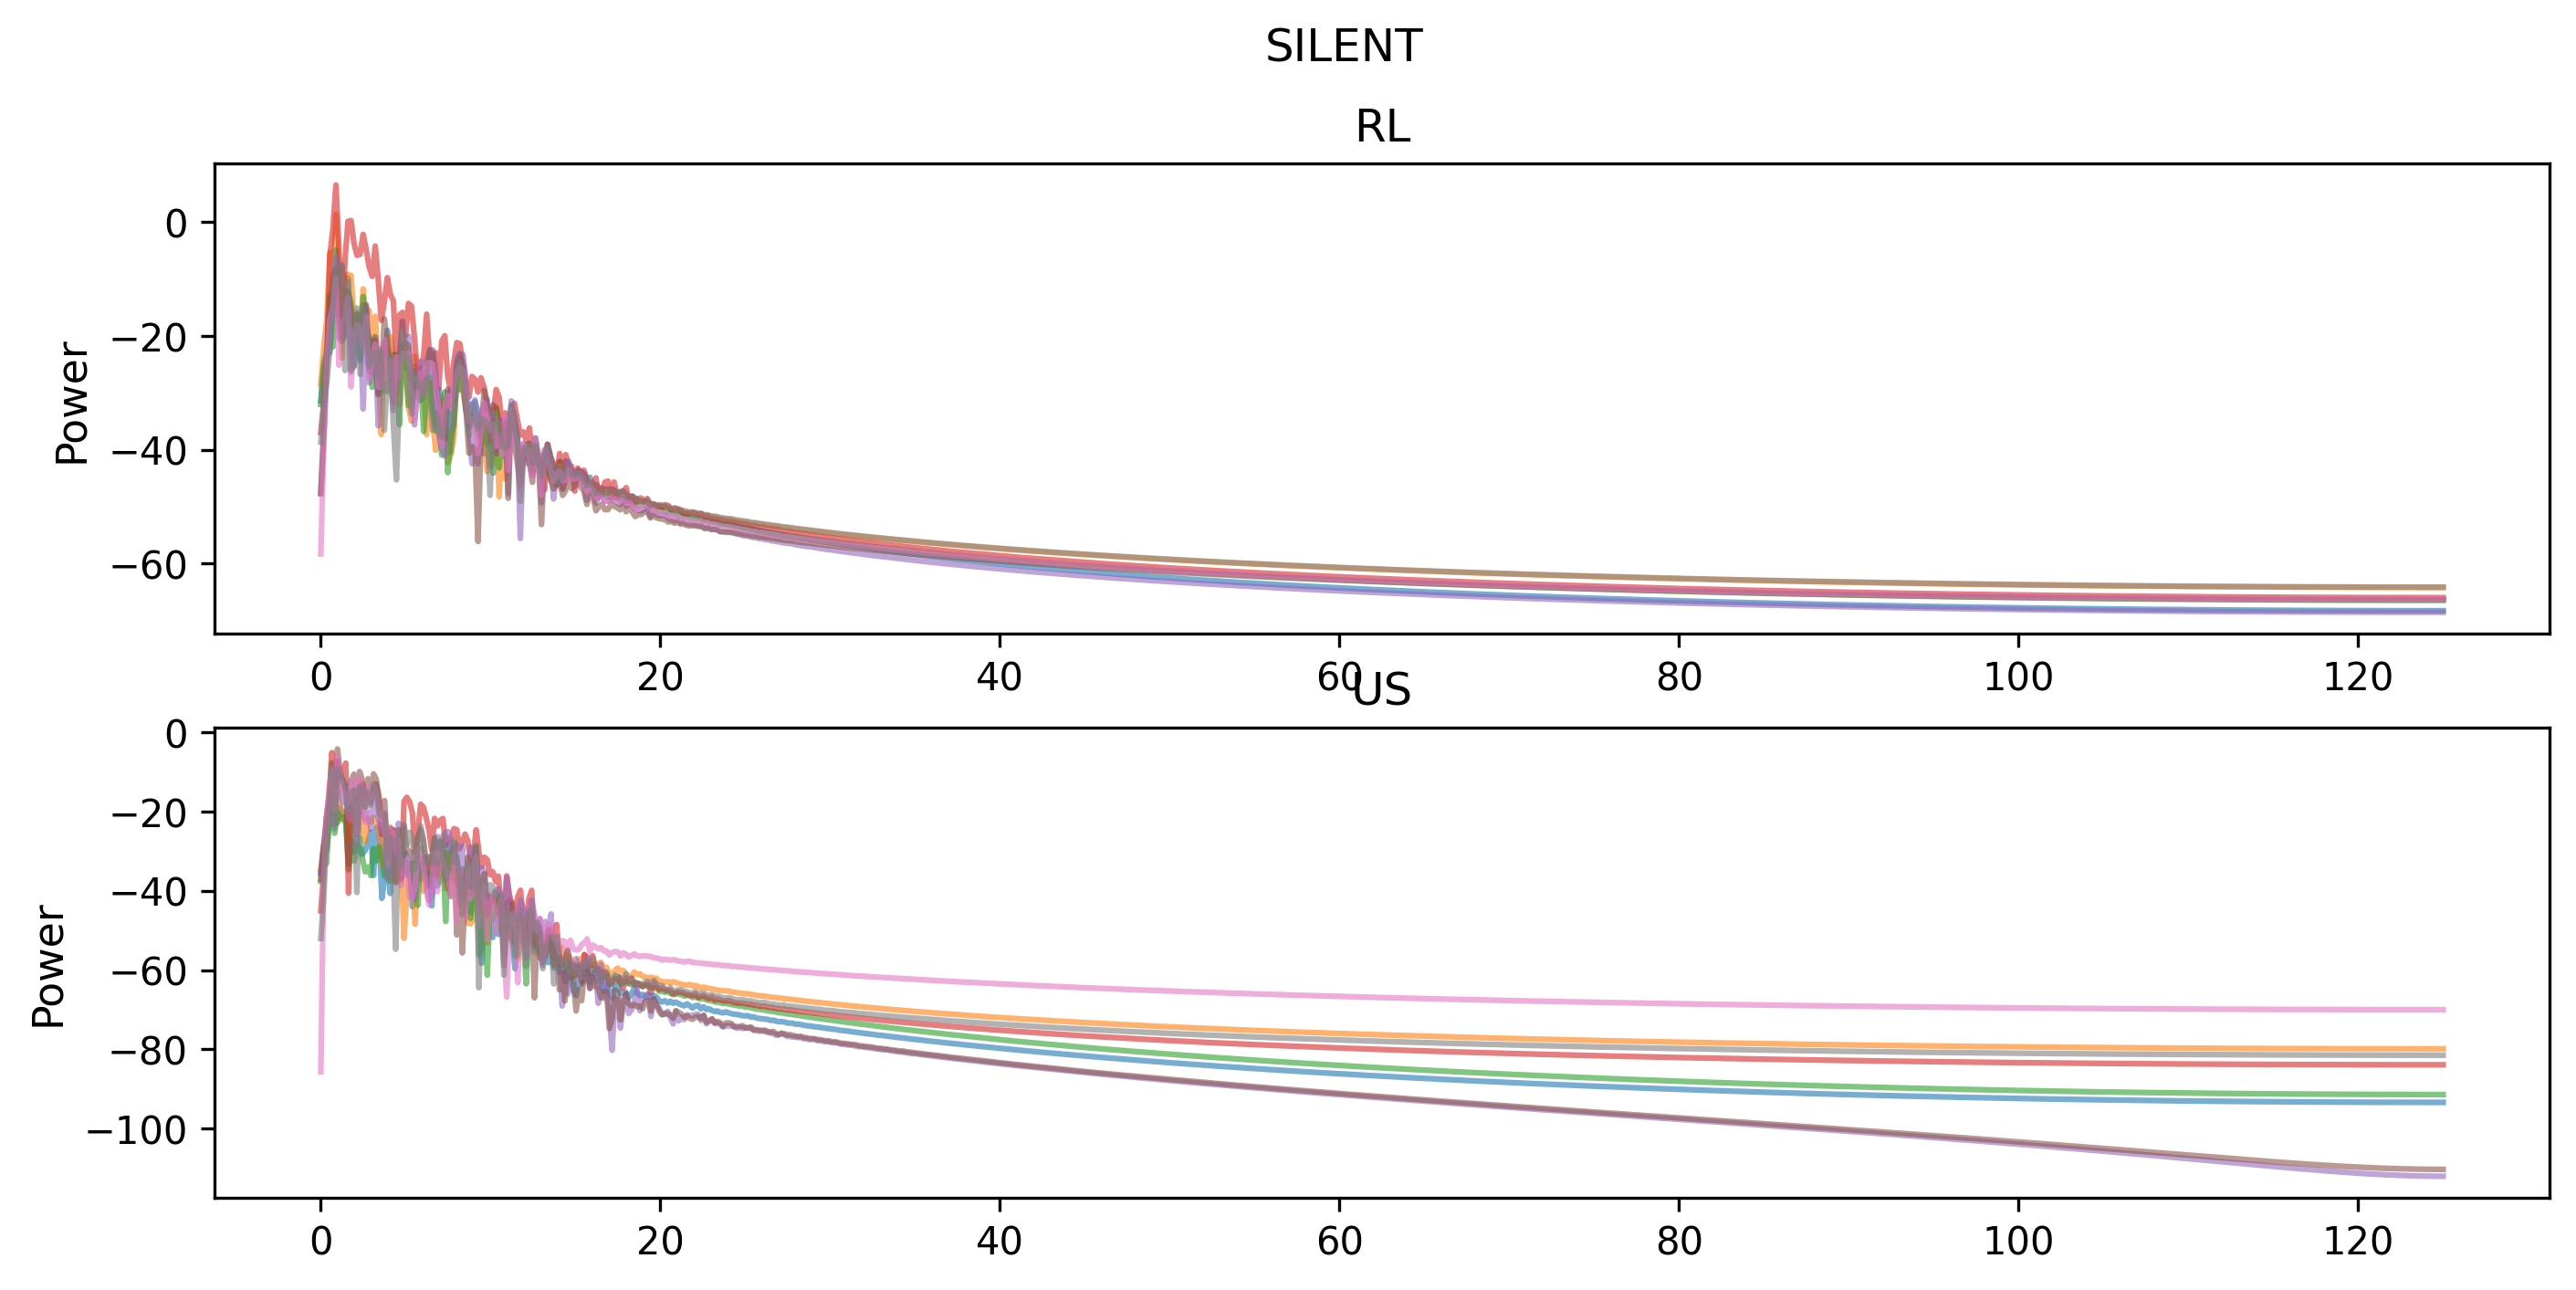

In [58]:
power_spec(data1=get_sample(1, 'RL', SENTENCES[0]),data2=get_sample(1, 'US', SENTENCES[0]),MODE="SILENT")

In [79]:
# STFT(data1=get_sample(1, 'RL', SENTENCES[0]), data2=get_sample(1, 'US', SENTENCES[0]),MODE="SILENT")

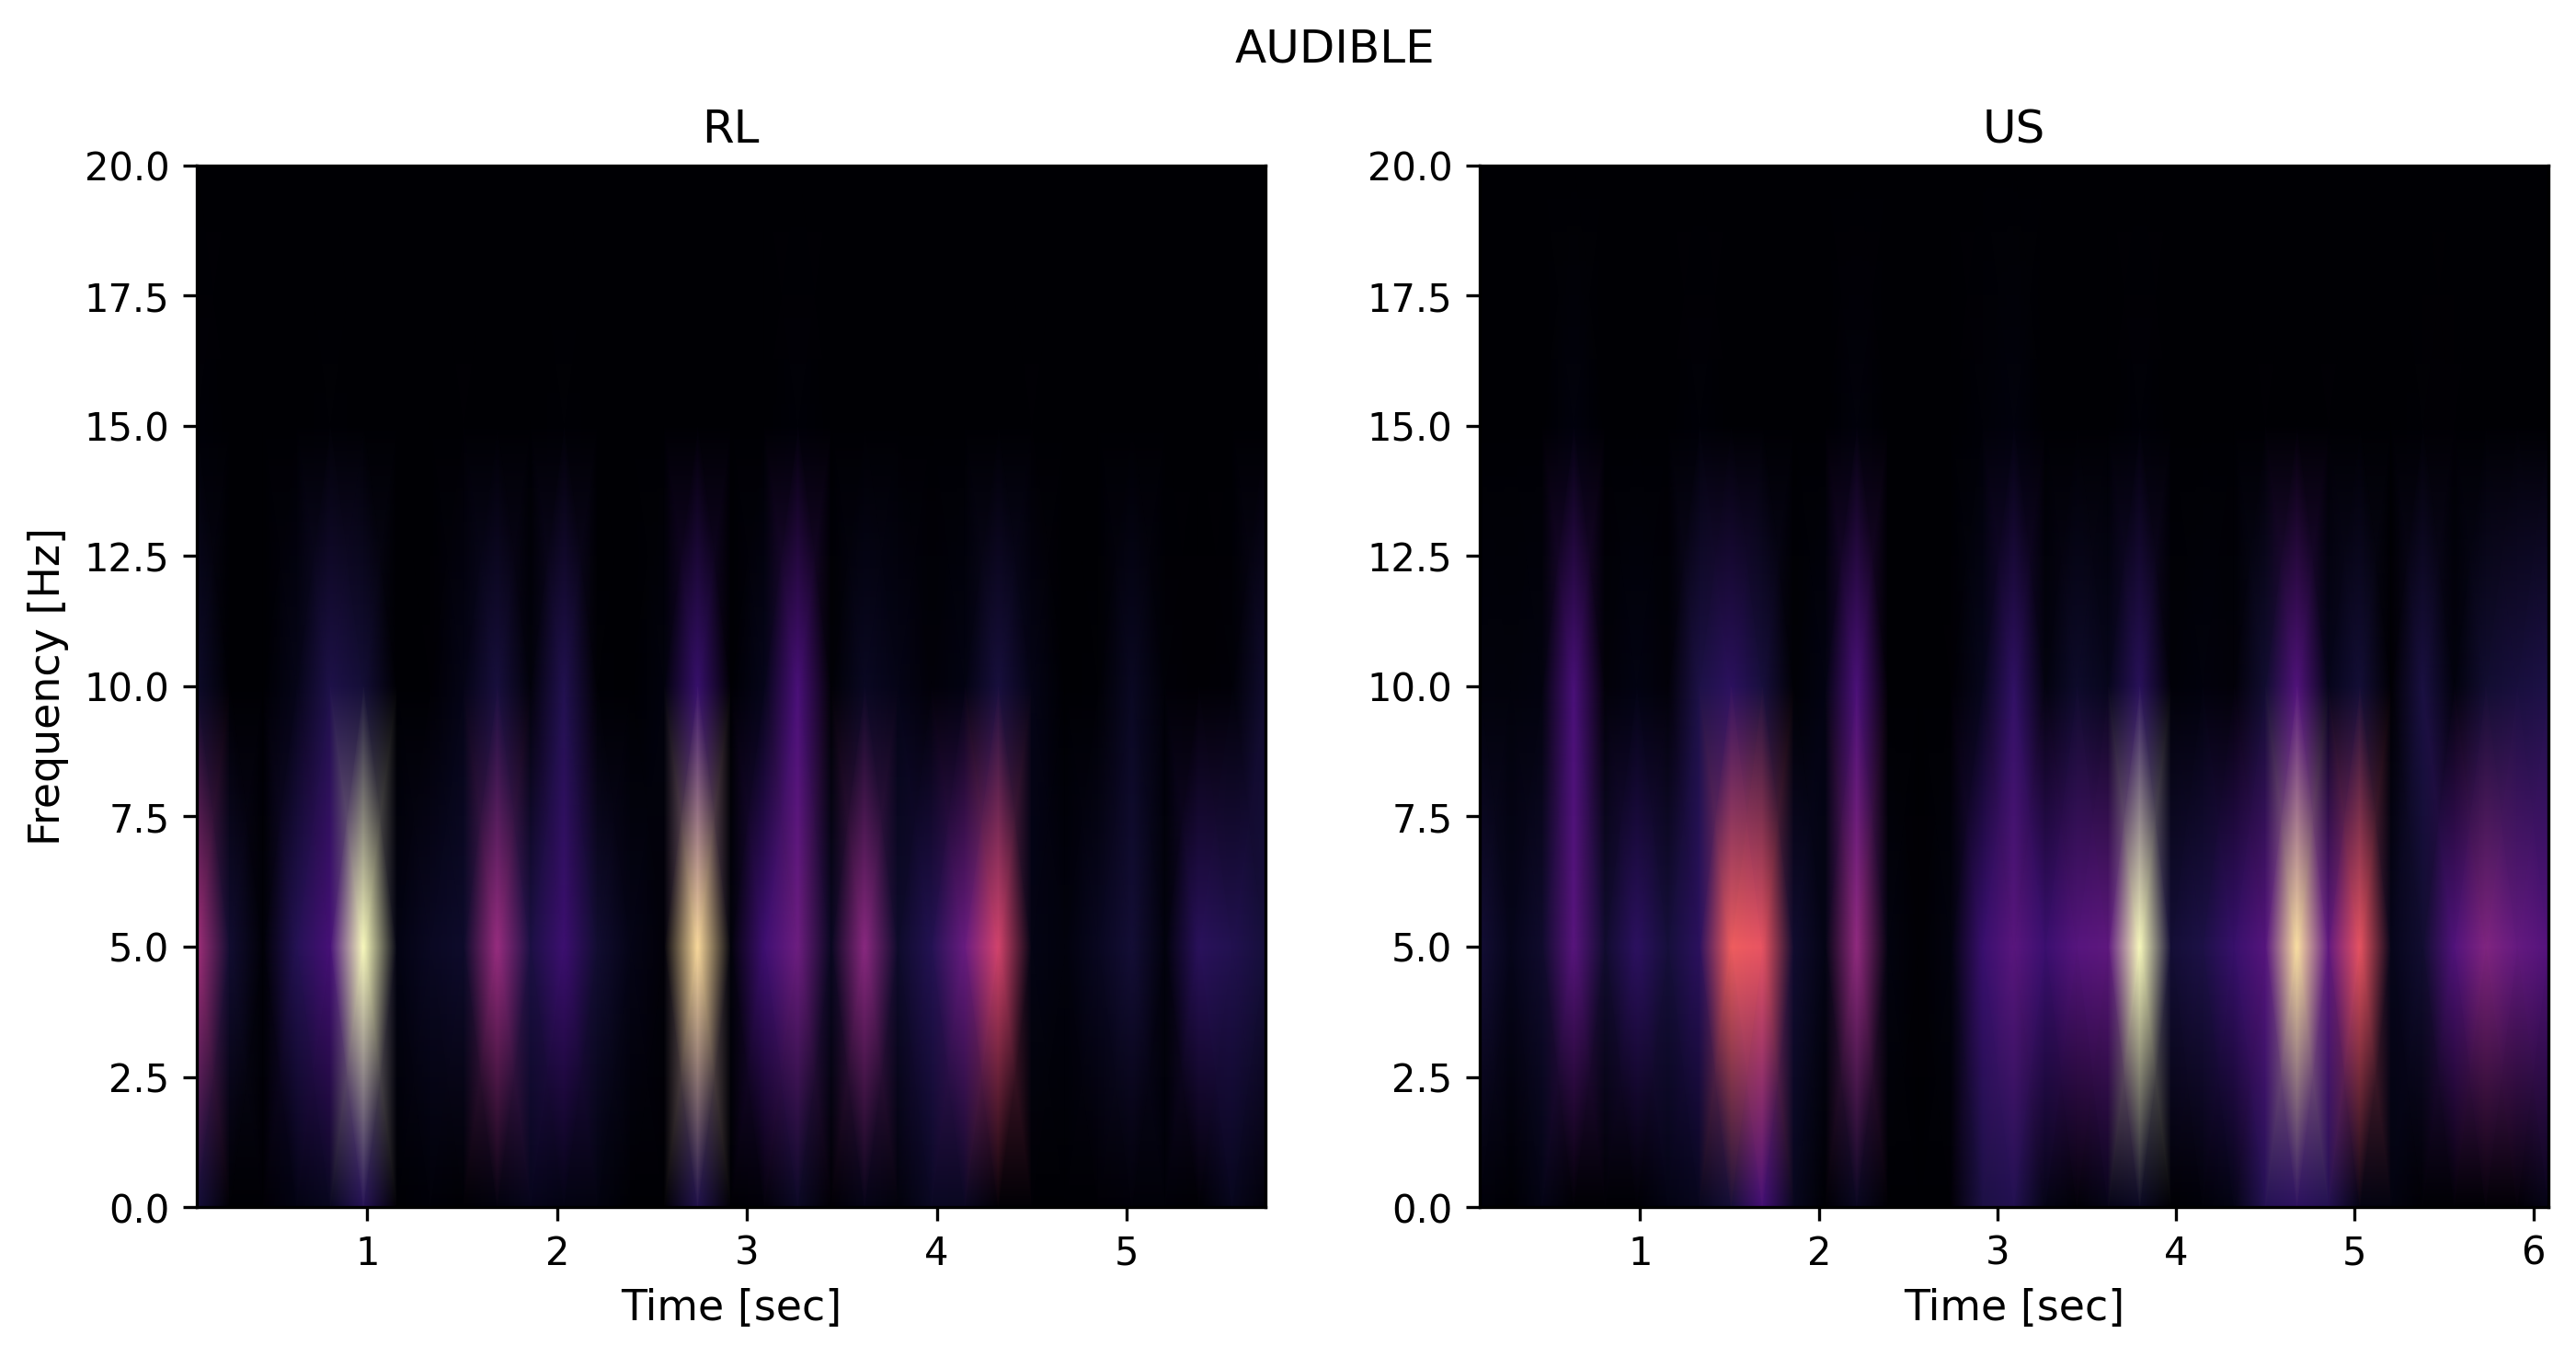

In [83]:
SPECTOGRAM(data1=get_sample(1, 'RL', SENTENCES[4]), data2=get_sample(1, 'US', SENTENCES[3]),MODE="AUDIBLE")
